In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from amuse.units import units, constants
from amuse.io import read_set_from_file
import argparse
import os
import glob
from amuse.ext.orbital_elements import get_orbital_elements_from_binaries
from amuse.lab import Particles, Particle
from tqdm import tqdm
from scipy.optimize import curve_fit

from plotter import get_com, get_com_vel, plot_inc_ecc, plot_ang_ecc, plot_binary_disk_arrow  # Importing also changes mpl.rcParams to make plots nice


Saving all files in: /data2/vdvuurst/AMUSE



# Lucas analyzing his vary-radii-True runs starting at rmin 6.55 AU and rmax 13.35 AU

In [3]:
# The runs where Fi crashed need to be processed again from the snapshots, because the summarizing diagnostics weren't saved

def dissect_system(particle_system):
    disk = particle_system[particle_system.name == 'disk'].copy()
    stars = particle_system[np.logical_or(particle_system.name == 'primary_star', particle_system.name == 'secondary_star')].copy()

    # Initialize com as a particle with the total stellar mass
    com = Particle()
    com.position = get_com(stars)
    com.velocity = get_com_vel(stars)
    com.mass = 0 | units.Msun
    for star in stars: # Works for both single and double star
        com.mass += star.mass 
    return disk, stars, com


def get_bound_elements(particle_system):
    disk, _, com = dissect_system(particle_system)
    m1, m2, ax, ecc, anom, inc, asc, peri = get_orbital_elements_from_binaries(com, disk, G=constants.G)
    return m1, m2, ax, ecc, anom, inc, asc, peri
    

def get_N_bound(particle_system):
    _, _, _, eccs, _, _, _, _ = get_bound_elements(particle_system)
    bound = eccs < 1
    return np.sum(bound)


def get_sorted_files(file_dir):
    unsorted_datafiles = glob.glob(file_dir + '/*.hdf5')
    file_numbers = [filename.split('_')[-1].split('.')[0] for filename in unsorted_datafiles]
    file_numbers = list(map(int, file_numbers))
    _, datafiles = zip(*sorted(zip(file_numbers, unsorted_datafiles)))
    return datafiles


def get_nbound_over_time(file_dir, save_name):
    nbound = []
    for datafile in tqdm(get_sorted_files(file_dir)):
        snapshot = read_set_from_file(datafile)
        nbound.append(get_N_bound(snapshot))

    np.save(save_name, np.array(nbound))


# Takes an hour or so

file_dir = './amuseKL-output/vary_radii-True/snapshots-rmin7.589-rmax10.989'  # First try for these initial conditions
save_name = './amuseKL-output/vary_radii-True/Nbound_rmin7.589-rmax10.989'
# get_nbound_over_time(file_dir, save_name)

file_dir = '/data2/pouw/amuse-project/amuseKL-output/r_min-7.589-r_max-10.989/snapshots-rmin7.589-rmax10.989'  # Second try for these initial conditions
save_name = '/data2/pouw/amuse-project/amuseKL-output/r_min-7.589-r_max-10.989/Nbound_rmin7.589-rmax10.989'
# get_nbound_over_time(file_dir, save_name)

    

Check if every step got saved: 80436, 80437


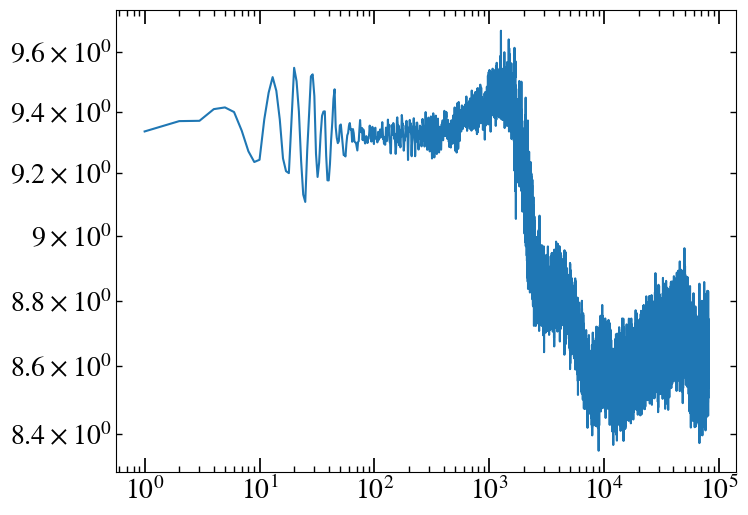

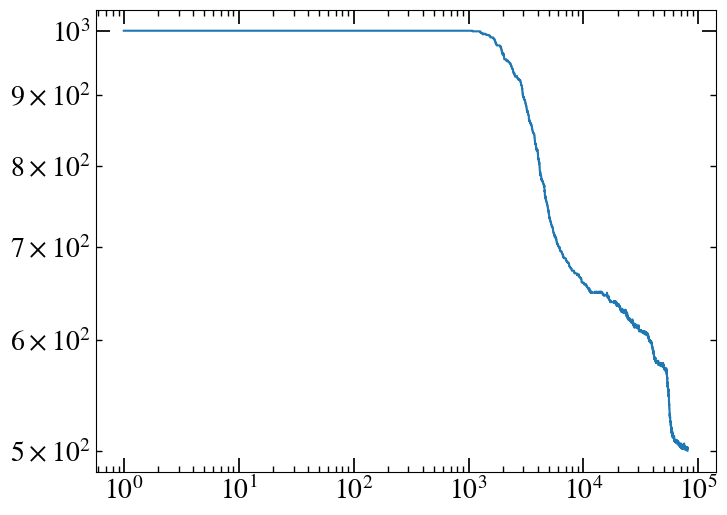

In [61]:
time = np.load('/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/times-year-7.400-11.480.npy', allow_pickle=True)
times = [t.value_in(units.yr) for t in time]
print(f'Check if every step got saved: {int(times[-1])}, {len(times)}')

rhalf = np.load('/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/Rhalf_rmin7.400-rmax11.480.npy', allow_pickle=True)  # Does not include t=0
nbound = np.load('/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/Nbound_rmin7.400-rmax11.480.npy', allow_pickle=True)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(times[1:], rhalf)
ax.loglog()
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(times[1:], nbound)
ax.loglog()
plt.show()


Check if every step got saved: 11932, 11934
Check if every step got saved: 14617, 14619
Check if every step got saved: 20312, 20314
Check if every step got saved: 102818, 102819
Check if every step got saved: 80436, 80437
Plotting the two crashed runs...


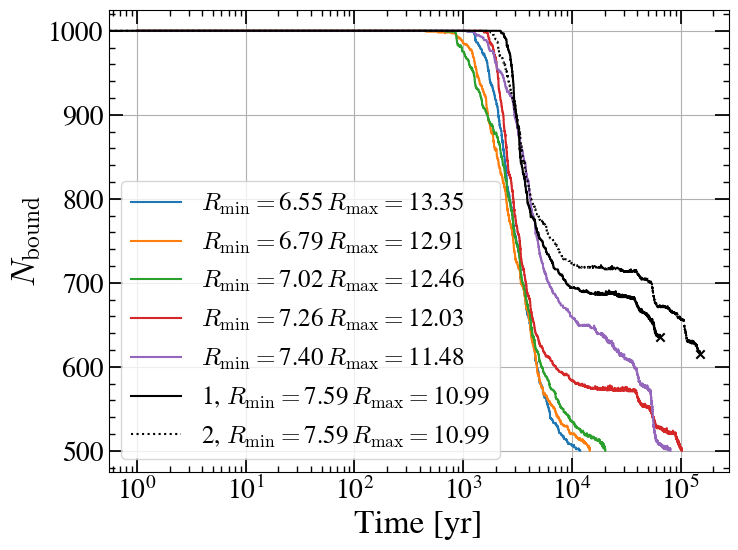

In [5]:
rmins = np.array([6.550, 6.788, 7.016, 7.265, 7.400, 7.589])
rmaxs = np.array([13.35, 12.908, 12.456, 12.025, 11.480, 10.989])

fig, ax = plt.subplots(figsize=(8,6))
for rmin, rmax in zip(rmins, rmaxs):

    if rmin != 7.589:
        time = np.load(f'/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/times-year-{rmin:.3f}-{rmax:.3f}.npy', allow_pickle=True)
        times = [t.value_in(units.yr) for t in time]
        print(f'Check if every step got saved: {int(times[-1])}, {len(times)}')

        nbound = np.load(f'/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/Nbound_rmin{rmin:.3f}-rmax{rmax:.3f}.npy', allow_pickle=True)  # Does NOT include t=0
        ax.plot(times[1:], nbound, label=r'$R_{\rm min}=$' + f'{rmin:.2f}' + r'$\, R_{\rm max}=$' + f'{rmax:.2f}')

    else:
        print('Plotting the two crashed runs...')

        nbound1 = np.load('/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/Nbound_rmin7.589-rmax10.989.npy', allow_pickle=True)  # Includes t=0
        time = np.arange(len(nbound1))
        ax.plot(time, nbound1, label=r'1, $R_{\rm min}=$' + f'{rmin:.2f}' + r'$\, R_{\rm max}=$' + f'{rmax:.2f}', color='black', linestyle='solid')
        ax.scatter(time[-1], nbound1[-1], marker='x', color='black')

        nbound2 = np.load('/data2/pouw/amuse-project/amuseKL-output/r_min-7.589-r_max-10.989/Nbound_rmin7.589-rmax10.989.npy', allow_pickle=True)  # Includes t=0
        time = np.arange(len(nbound2))
        ax.plot(time, nbound2, label=r'2, $R_{\rm min}=$' + f'{rmin:.2f}' + r'$\, R_{\rm max}=$' + f'{rmax:.2f}', color='black', linestyle='dotted')
        ax.scatter(time[-1], nbound2[-1], marker='x', color='black')
        

ax.semilogx()
ax.legend(fontsize=18)
ax.set_xlabel('Time [yr]')
ax.set_ylabel(r'$N_{\rm bound}$')
ax.grid()
plt.show()


1. The shape is similar: stable, drop, plateau that decreases somewhat stepwise
2. The initial conditions mainly determine the post-drop plateau height, but also the start of the drop
3. There is some variance in the post-drop plateau height at the same initial conditions
4. We observe a clear plateau after the initial drop in three runs: the two black colored and the red colored -> see if they have settled into disks with the same inner and outer radii

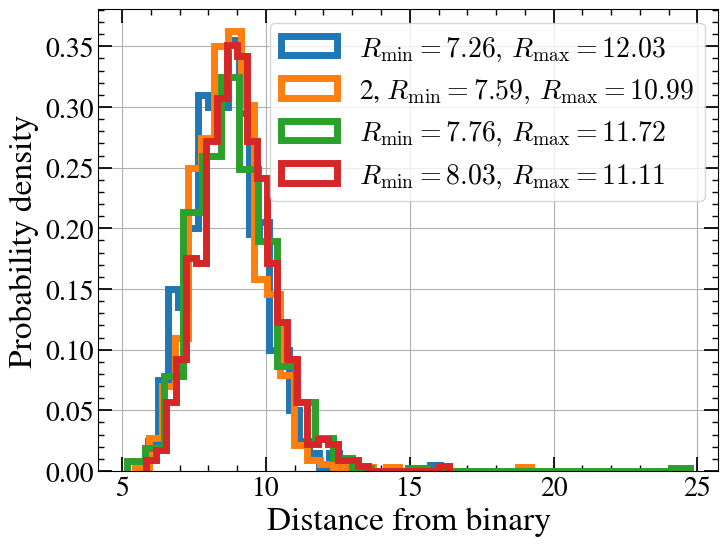

The inner and outer radii at 1 sigma are [ 7.99880008  8.08126932  8.07885872  8.33241152] and [ 9.22614726  9.28245307  9.55747754  9.59513866]. This gives a mean of 8.12 and 9.42 AU.
The inner and outer radii at 2 sigma are [ 7.38512648  7.48067745  7.33954931  7.70104795] and [  9.83982085   9.88304494  10.29678694  10.22650223]. This gives a mean of 7.48 and 10.06 AU.


In [194]:
# We choose to analyze the disk at 25 kyr, in the middle of the plateaus

file_idx = 25000
dirs = np.array(['/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/snapshots-rmin7.265-rmax12.025',
                 '/data2/pouw/amuse-project/amuseKL-output/r_min-7.589-r_max-10.989/snapshots-rmin7.589-rmax10.989',
                 '/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data/r_min-7.625-r_max-12.025-vary_radii-True/snapshots-rmin7.763-rmax11.723',
                 '/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data/r_min-7.625-r_max-12.025-vary_radii-True/snapshots-rmin8.027-rmax11.107'])
labels = np.array([r'$R_{\rm min}=7.26, \, R_{\rm max}=12.03$', 
                   r'2, $R_{\rm min}=7.59, \, R_{\rm max}=10.99$',
                   r'$R_{\rm min}=7.76, \, R_{\rm max}=11.72$',
                   r'$R_{\rm min}=8.03, \, R_{\rm max}=11.11$'])
# dirs = np.array(['/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/snapshots-rmin7.400-rmax11.480',
#                  '/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/snapshots-rmin7.265-rmax12.025',
#                  '/data2/pouw/amuse-project/amuseKL-output/vary_radii-True/snapshots-rmin7.589-rmax10.989',
#                  '/data2/pouw/amuse-project/amuseKL-output/r_min-7.589-r_max-10.989/snapshots-rmin7.589-rmax10.989'])
# labels = np.array([r'$R_{\rm min}=7.40 \, R_{\rm max}=11.48$',
#                    r'$R_{\rm min}=7.26 \, R_{\rm max}=12.03$', 
#                    r'1, $R_{\rm min}=7.59 \, R_{\rm max}=10.99$', 
#                    r'2, $R_{\rm min}=7.59 \, R_{\rm max}=10.99$'])

medians = np.zeros(len(dirs))
stds = np.zeros(len(dirs))

plt.figure(figsize=(8,6))
for i, snapshot_dir in enumerate(dirs):
    file = get_sorted_files(snapshot_dir)[file_idx]
    data = read_set_from_file(file)

    _, _, _, ecc, _, inc, asc, peri = get_bound_elements(data)
    bound = ecc < 1
    
    disk, _, com = dissect_system(data)
    disk.position -= com.position
    bound_disk_pos = np.linalg.norm(disk[bound].position.value_in(units.AU), axis=1)

    plt.hist(bound_disk_pos, density=True, bins=30, histtype='step', linewidth=5, label=labels[i])

    medians[i] = np.median(bound_disk_pos)
    stds[i] = np.std(bound_disk_pos)

    # fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
    # plot_binary_disk_arrow(np.array([ax1, ax2, ax3]), data)
    # # plot_ang_ecc(ax4, 
    # #             file_idx | units.yr, 
    # #             inc.median(),
    # #             asc.median(),
    # #             peri.median(),
    # #             ecc.median())
    # fig.suptitle(f'Time = {file_idx} year', fontsize=28)
    # plt.tight_layout()
    # fig.show()

plt.ylabel('Probability density')
plt.xlabel('Distance from binary')
plt.grid()
plt.legend()
plt.show()

inners_1sig = medians - stds / 2
outers_1sig = medians + stds / 2
inners_2sig = medians - stds
outers_2sig = medians + stds
print(f'The inner and outer radii at 1 sigma are {inners_1sig} and {outers_1sig}. This gives a mean of {np.mean(np.array(inners_1sig)):.2f} and {np.mean(np.array(outers_1sig)):.2f} AU.')
print(f'The inner and outer radii at 2 sigma are {inners_2sig} and {outers_2sig}. This gives a mean of {np.mean(np.array(inners_2sig)):.2f} and {np.mean(np.array(outers_2sig)):.2f} AU.')


# Tim's data

In [173]:
DATAPATH = '/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data/'
def get_snapshot_paths():
    #function to scrape all snapshot and run roots from all runs (excluding any no_disk run explicitly)
    datadirs = []
    roots = []
    for root,dirs,files in os.walk(DATAPATH):
        for dir in dirs:
            if 'snapshot' in dir and 'no_disk' not in root:
                datadirs.append(os.path.join(root,dir))
                if root not in roots:
                    roots.append(root)
    return datadirs,roots

def rectify_filenames(root):
    #sometimes, the .npy files are named inconsistently. This fixes that.
    for elem in get_npy_paths(root):
        for e in elem:
            head,tail = os.path.split(e)
            tail = tail.replace('rmin','').replace('rmax','')
            new_filename = os.path.join(head,tail)
            if e != new_filename:
                os.rename(e,new_filename)
                # print(f'Renaming {e} to {new_filename}')

# for root in run_roots:
#     rectify_filenames(root)

def _get_npy_paths(root):
    # get all paths to .npy files given the root directory of a run
    files = np.sort(glob.glob(root + '/*.npy'))
    times,grav_energy,hydro_energy, nbound, rhalf = [],[],[],[],[]
    for f in files:
        if 'times' in f:
            times.append(f)
        elif 'grav' in f:
            grav_energy.append(f)
        elif 'hydro' in f:
            hydro_energy.append(f)
        elif 'Nbound' in f:
            nbound.append(f)
        elif 'Rhalf' in f:
            rhalf.append(f)
        else:
            raise ValueError('Encountered some weird stuff, there is .npy file that should not exist')

    return times,grav_energy,hydro_energy, nbound, rhalf

def get_npy_paths(root):
    #uses above function but with nicer output
    return list(zip(*_get_npy_paths(root)))



In [174]:
snapshot_dirs,run_roots = get_snapshot_paths()

In [ ]:
##To check if get_npy_paths groups the files together correctly
# for root in run_roots:
#     print(root)
#     for elem in get_npy_paths(root):
#         for e in elem:
#             print(os.path.split(e)[-1])
#         print()

In [180]:
def get_rmin_rmax_from_run(root):
    info_strings = np.array(os.path.split(root)[-1].split('-'))
    print()
    if 'r_min' in info_strings and 'r_max' in info_strings:
        rmin = float(info_strings[np.where(np.array(info_strings) == 'r_min')[0][0] + 1])
        rmax = float(info_strings[np.where(np.array(info_strings) == 'r_max')[0][0] + 1])
    elif 'r_min' in info_strings and 'r_max' not in info_strings:
        rmin = float(info_strings[np.where(np.array(info_strings) == 'r_min')[0][0] + 1])
        rmax = 13.35 #default value
    elif 'r_max' in info_strings and 'r_min' not in info_strings:
        rmax = float(info_strings[np.where(np.array(info_strings) == 'r_max')[0][0] + 1])
        rmin = 6.55 #default vlaue
    else:
        rmin = 6.55
        rmax = 13.35
    
    return rmin, rmax

get_rmin_rmax_from_run(run_roots[0])

(5.767, 6.792)

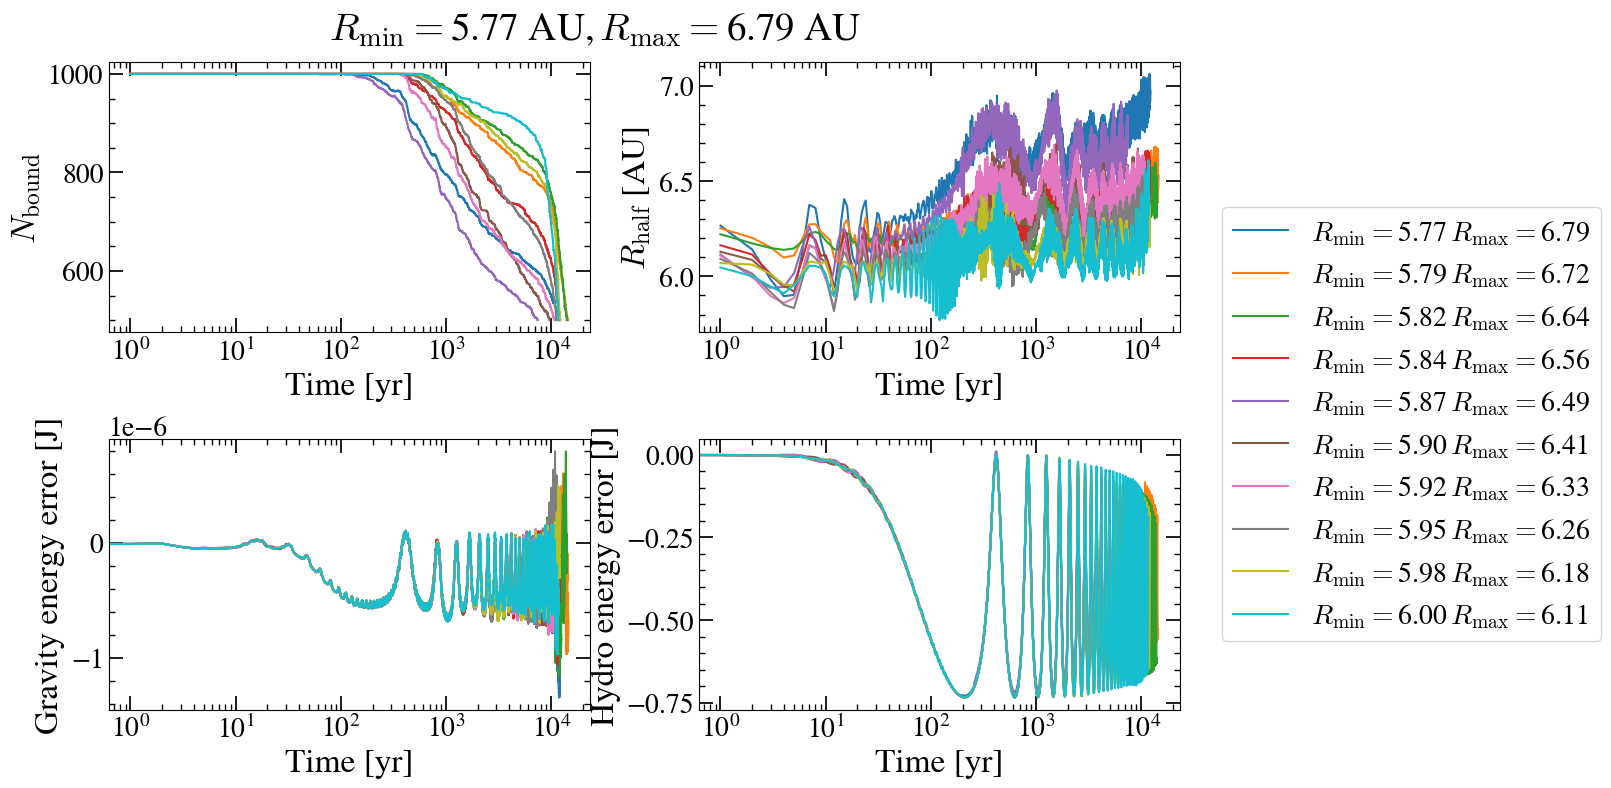

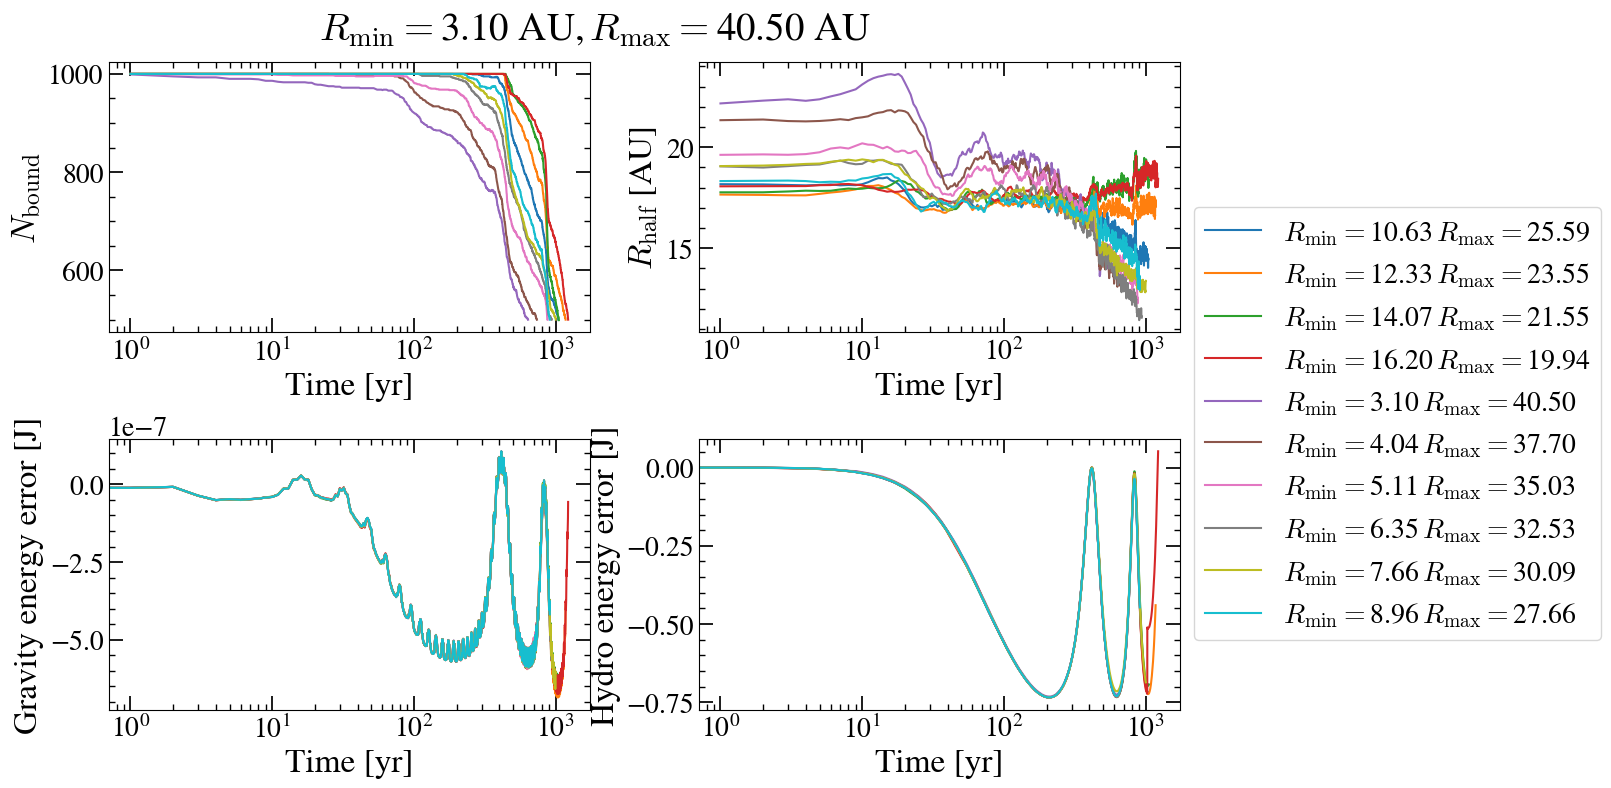

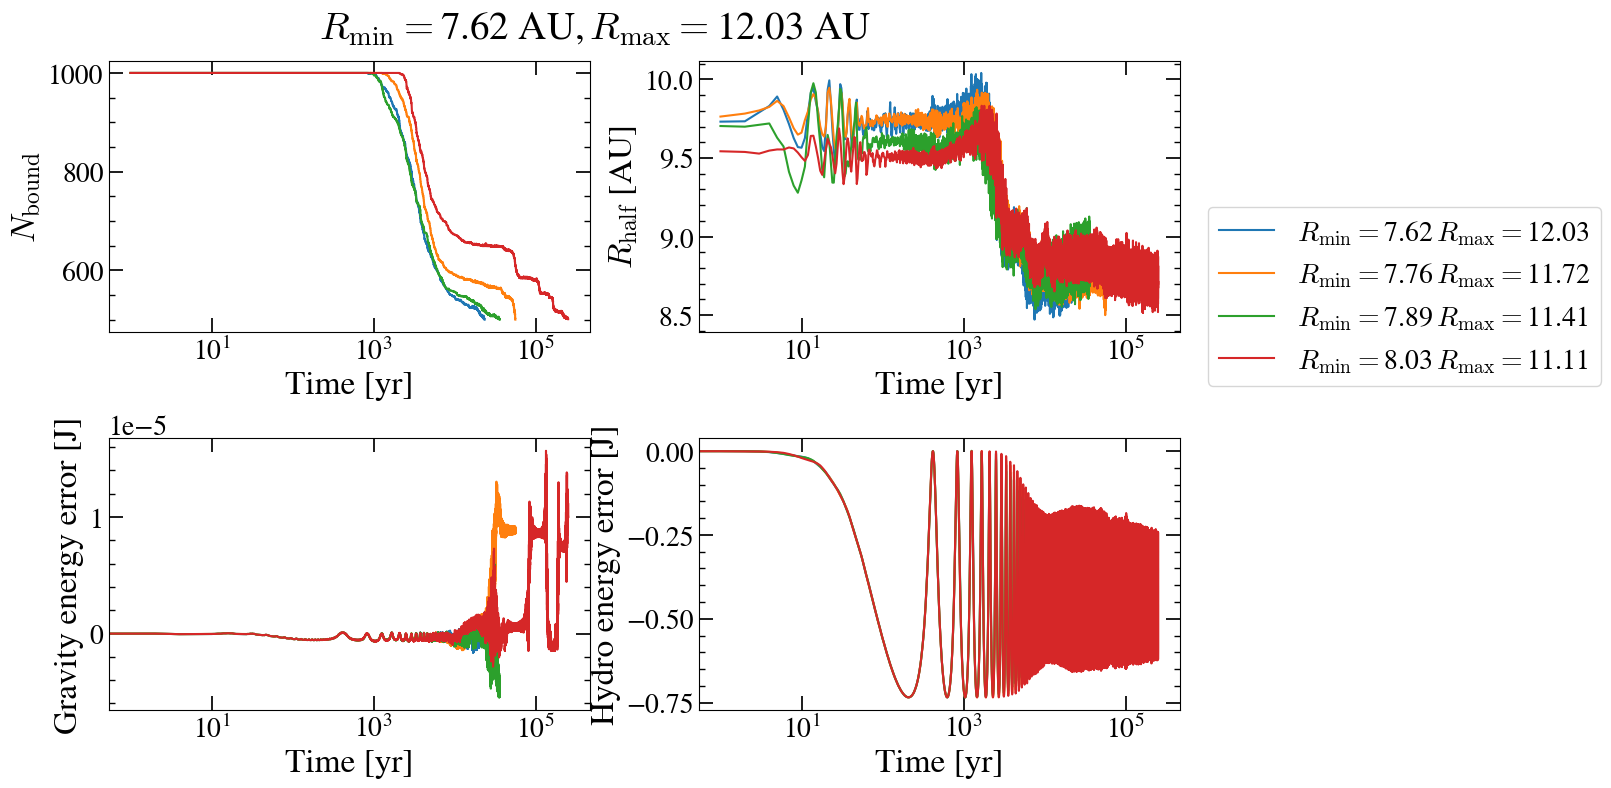

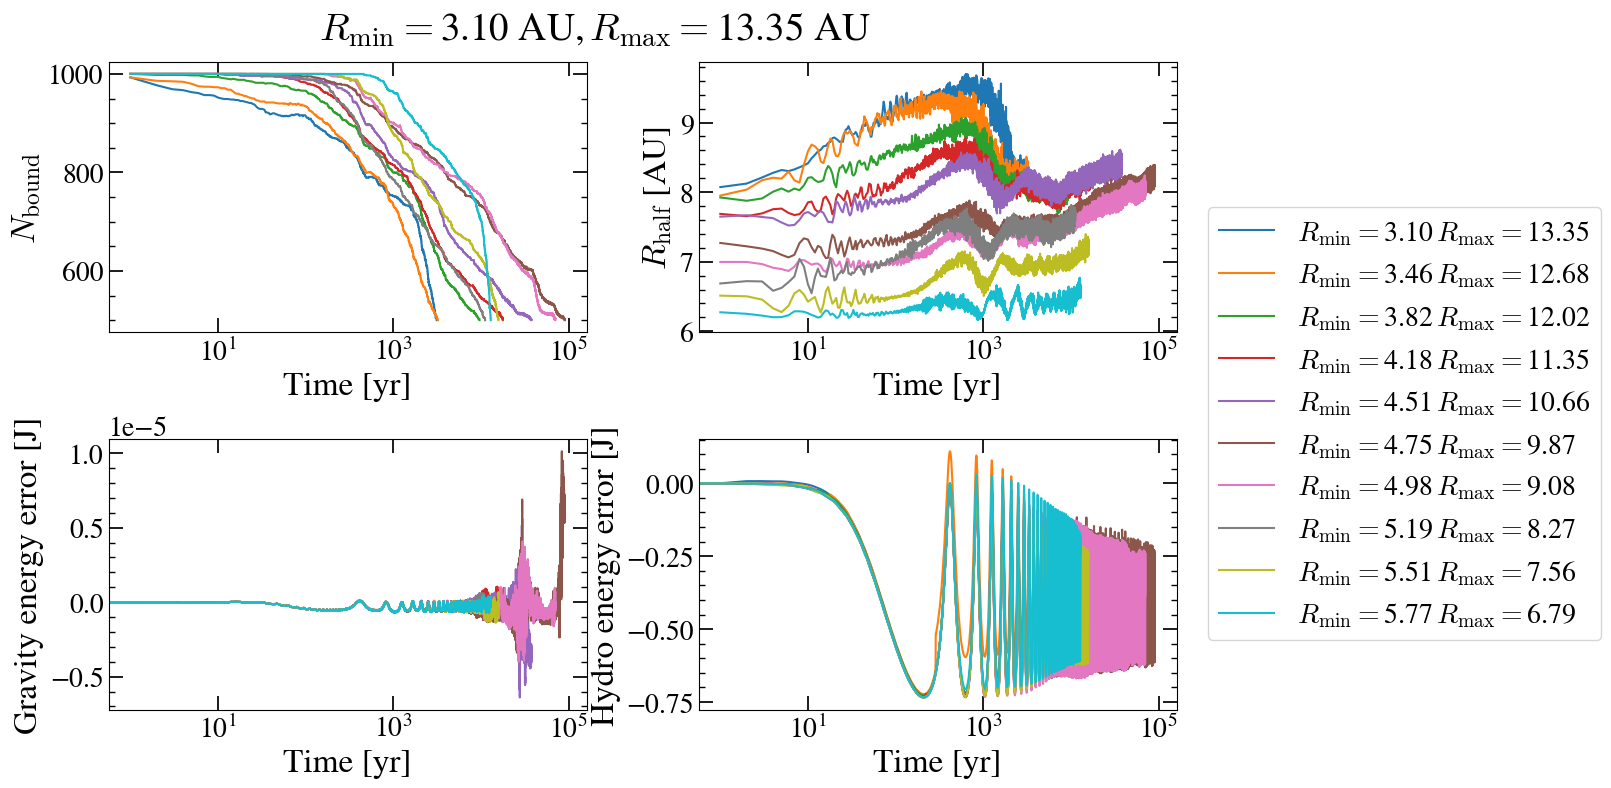

In [188]:
def process_run(root):
    #given the root of a run (with various simulations in it), get the various arrays and make plots
    
    run_paths = get_npy_paths(root) #get relevant npy files 

    fig,axes = plt.subplots(figsize=(12,8),nrows=2,ncols=2,tight_layout=True)
    rmin_run, rmax_run = get_rmin_rmax_from_run(root)
    fig.suptitle(r'$R_{\rm min}=$' + f'{rmin_run:.2f} AU,' + r'$\, R_{\rm max}=$' + f'{rmax_run:.2f} AU',fontsize=28)
    
    for i,(time_path,grav_path,hydro_path,Nbound_path,Rhalf_path) in enumerate(run_paths): #iterate per sim
        rmin,rmax = os.path.split(time_path)[-1].strip('.npy').split('-')[-2:] #extract rmin and rmax from filepath
        rmin,rmax = float(rmin),float(rmax)
        try:
            times = np.load(time_path)
            grav_energy = np.load(grav_path)
            grav_energy_error = (grav_energy - grav_energy[0]) / grav_energy[0]
            hydro_energy = np.load(hydro_path)
            hydro_energy_error = (hydro_energy - hydro_energy[0]) / hydro_energy[0]
            Nbound = np.load(Nbound_path)
            Rhalf = np.load(Rhalf_path)
        except ValueError: #units were not removed in this run, remove them manually
            print(f'Units found in arrays. Removing manually...')
            times = np.load(time_path,allow_pickle = True)
            times = [t.value_in(units.yr) for t in times]

            grav_energy = np.load(grav_path,allow_pickle = True)
            grav_energy = [g.value_in(units.J) for g in grav_energy]

            hydro_energy = np.load(hydro_path,allow_pickle = True)
            hydro_energy = [h.value_in(units.J) for h in hydro_energy]

            Nbound = np.load(Nbound_path,allow_pickle = True) #never any units

            Rhalf = np.load(Rhalf_path,allow_pickle = True)
            Rhalf = [r.value_in(units.AU) for r in Rhalf]
        
        axes[0,0].plot(times[1:],Nbound,label = r'$R_{\rm min}=$' + f'{rmin:.2f}' + r'$\, R_{\rm max}=$' + f'{rmax:.2f}')
        axes[0,0].semilogx()
        axes[0,0].set(xlabel='Time [yr]',ylabel=r'$N_{\rm bound}$')

        axes[0,1].plot(times[1:],Rhalf)
        axes[0,1].semilogx()
        axes[0,1].set(xlabel='Time [yr]',ylabel=r'$R_{\rm half}$ [AU]')

        axes[1,0].plot(times,grav_energy_error)
        axes[1,0].semilogx()
        axes[1,0].set(xlabel='Time [yr]',ylabel=r'Gravity energy error [J]')

        axes[1,1].plot(times,hydro_energy_error)
        axes[1,1].semilogx()
        axes[1,1].set(xlabel='Time [yr]',ylabel=r'Hydro energy error [J]')
        

    handles,labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles,labels,bbox_to_anchor=(1.35,0.75))
    fig.tight_layout()
    plt.show()

for root in run_roots:
    process_run(root)
    
        
         


# Everything below is old

Small test for correct output

In [3]:
if 'amuseKL-output' not in os.getcwd():
    os.chdir('amuseKL-output')

testglob = glob.glob('t_end-10.0-vary_radii-True/*.npy')
for file in testglob:
    try:
        print(file)
        print(np.load(file,allow_pickle=False))
        print()
    except ValueError as e:
        print(f'{e} for {file}')
        print()

t_end-10.0-vary_radii-True/outer_rad_au.npy
[ 13.35]

t_end-10.0-vary_radii-True/times-years-6.550-13.350.npy
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]

t_end-10.0-vary_radii-True/Rhalf_6.55-13.35.npy
[ 9.75018712  9.7755794   9.80868251  9.83091118  9.87642008  9.86100721
  9.75699076  9.70084628  9.61432475  9.57896554]

t_end-10.0-vary_radii-True/inner_rad_au.npy
[ 6.55]

t_end-10.0-vary_radii-True/hydro-energy-joules-6.550-13.350.npy
[  1.29817089e+36   1.29814298e+36   1.29782499e+36   1.29718100e+36
   1.29573426e+36   1.29274056e+36   1.28918927e+36   1.28506292e+36
   1.28157999e+36   1.27835766e+36   1.27482983e+36]

t_end-10.0-vary_radii-True/grav-energy-joules-6.550-13.350.npy
[ -1.47597775e+42  -1.47597774e+42  -1.47597774e+42  -1.47597770e+42
  -1.47597768e+42  -1.47597768e+42  -1.47597768e+42  -1.47597768e+42
  -1.47597768e+42  -1.47597769e+42  -1.47597769e+42]

t_end-10.0-vary_radii-True/inner_fraction.npy
[ nan]

t_end-10.0-vary_radii-True/Nbound_6.55-13.

In [4]:
SNAPSHOT_DIR = '/data2/pouw/amuse-project/snapshots-yesdisk/'  # sorry for hard coding my own path...


In [5]:
unsorted_datafiles = glob.glob(SNAPSHOT_DIR + '*.hdf5')
file_numbers = [filename.split('_')[-1].split('.')[0] for filename in unsorted_datafiles]
file_numbers = list(map(int, file_numbers))
times, datafiles = zip(*sorted(zip(file_numbers, unsorted_datafiles)))
times = np.array(times) / 365  # In years
times = times.astype(int)  


In [11]:
median_incs = []
median_eccs = []
plot_time = []
n_bound_list = []

primaries = Particles()
secondaries = Particles()

print(f'Processing {len(datafiles)} snapshots...')
for time, datafile in tqdm(zip(times, datafiles)):
    data = read_set_from_file(datafile)  # Full particle set at single timestep

    primaries.add_particle(data[data.name == 'primary_star'])
    secondaries.add_particle(data[data.name == 'secondary_star'])

    ### USE THIS FOR GETTING ECCENTRICITIES OF THE DISK ###

    # disk = data[data.name == 'disk']
    # stars = data[ np.logical_or(data.name == 'primary_star', data.name == 'secondary_star') ]
    # com = Particle()
    # com.position = get_com(stars)
    # com.velocity = get_com_vel(stars)
    # com.mass = stars[0].mass + stars[1].mass

    # _, _, _, eccs, _, incs, _, _ = get_orbital_elements_from_binaries(com, disk, G=constants.G)

    # bound = eccs < 1
    # bound_eccs = eccs[bound]
    # bound_incs = incs[bound]
    # n_bound = np.sum(bound)

    # median_incs.append(np.median(bound_incs.value_in(units.deg)))
    # median_eccs.append(np.median(bound_eccs))
    plot_time.append(time)
    # n_bound_list.append(n_bound)
    

Processing 8251 snapshots...


8251it [02:02, 67.28it/s]


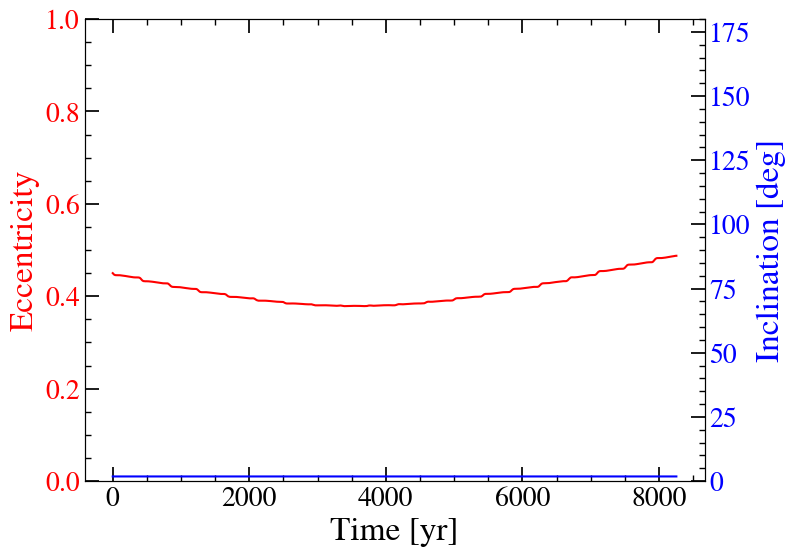

In [12]:
_, _, _, eccs, _, incs, _, _ = get_orbital_elements_from_binaries(primaries, secondaries, G=constants.G)

fig, ax = plt.subplots(figsize=(8,6))
plot_inc_ecc(ax, plot_time | units.yr, incs | units.deg, eccs)
plt.show()


In [ ]:
# np.save('n-bound.npy', np.array(n_bound_list))
# np.save('times-year.npy', np.array(plot_time))
# np.save('bound-incs.npy', np.array(median_incs))
# np.save('bound-eccs.npy', np.array(median_eccs))

In [ ]:
# Again, sorry

n_bound = np.load('/data2/pouw/amuse-project/output/n-bound.npy')
times = np.load('/data2/pouw/amuse-project/output/times-year.npy')
bound_incs = np.load('/data2/pouw/amuse-project/output/bound-incs.npy')
bound_eccs = np.load('/data2/pouw/amuse-project/output/bound-eccs.npy')

In [ ]:
def linear(x, a, b):
    return a * x + b

log_time = np.log10(times)
log_n = np.log10(n_bound)

param, pcov = curve_fit(linear, log_time[1800:], log_n[1800:])
print(param, pcov)



[-1.81180202  8.88559238] [[  6.47154106e-06  -2.37304981e-05]
 [ -2.37304981e-05   8.72282726e-05]]


/var/tmp/pouw/ipykernel_2596587/3464256015.py:17: RuntimeWarning: divide by zero encountered in log10
  log_time = np.log10(times)


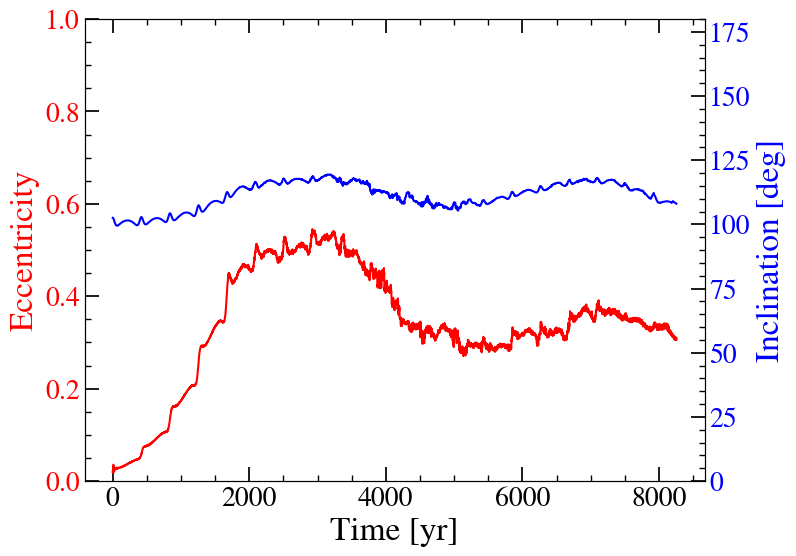

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
plot_inc_ecc(ax, times | units.yr, bound_incs | units.deg, bound_eccs)
plt.show()

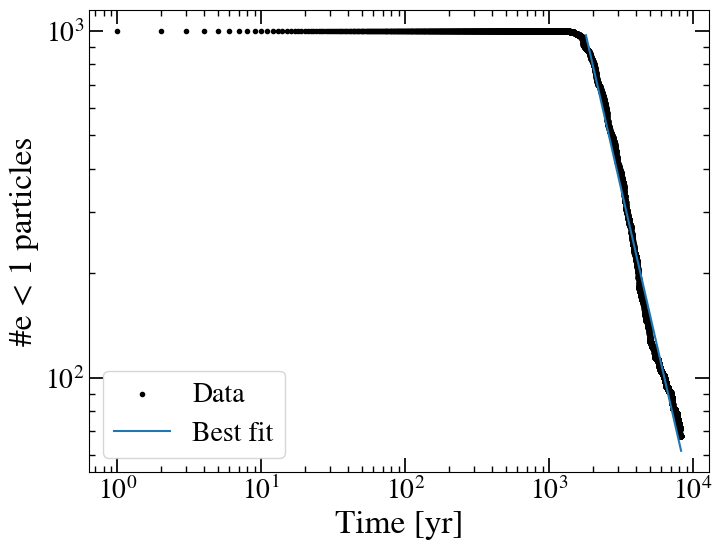

In [21]:
time_range = np.linspace(0, len(plot_time), 1000)

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(times, n_bound, color='black', marker='.', label='Data')
plt.plot(10**log_time[1800:], 10**linear(log_time[1800:], *param), label='Best fit')
# plt.vlines(t0_opt, 0, 1000, color='red', label='t0')
plt.legend()
plt.loglog()
plt.xlabel('Time [yr]')
plt.ylabel('#e < 1 particles')
plt.show()

